# Run VGG16 on 30 classes without tuning

In this part, we loads all qualified data (30 classes) in VGG16 and only add an output layer. 

However, based on accuracy and loss curves, we can clearly see that there exists severe overfitting. To address overfiting, adding noises, regularization may help.  

Obviously, we need to find out how we add layers can reduce overfitting as much as possible and maintain the accuracy at the same time. 

Therefore, we decide to use 3 classes which contains most paintings and 20 epochs for figuring out how we can train a better model. And then, we go back to 30 classes and compare the results with this untuning version.

In [1]:
import numpy as np
import os
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Validation of using GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1655678584681517339
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2264907776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15477623663351877341
physical_device_desc: "device: 0, name: GeForce GTX 970M, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Loading the pre-trained VGG16

In [3]:
import tensorflow.keras.backend as K
K.clear_session()

In [4]:
nrow = 200
ncol = 200
base_model = applications.VGG16(weights='imagenet', input_shape=(nrow,ncol,3), include_top=False)
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


Now, we only add a final fully-connected layer. Since this is a multiple classification, there should be 30 output and softmax activation.

In [5]:
model.add(Flatten())
model.add(Dense(30, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 50, 50, 256)       295168    
__________

## Using Generators to Load Data

In [6]:
train_data_dir = './images_train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 5687 images belonging to 30 classes.


In [7]:
test_data_dir = './images_test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = train_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 1404 images belonging to 30 classes.


## Train the model

Compile the model. we are performing multiple classification, so we use 'categorical_crossentropy' loss function.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

Now, we run the fit. Since we run 120 epochs, even with GPU, it will take hours (about 4 hours in our case).

In [9]:
nepochs = 120  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    epochs=nepochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
178/178 [==============================] - 183s 1s/step - loss: 2.3449 - acc: 0.3726 - val_loss: 1.8798 - val_acc: 0.4715
Epoch 2/120
178/178 [==============================] - 133s 748ms/step - loss: 1.4229 - acc: 0.5936 - val_loss: 1.8880 - val_acc: 0.5121
Epoch 3/120
178/178 [==============================] - 143s 805ms/step - loss: 1.1424 - acc: 0.6673 - val_loss: 1.8866 - val_acc: 0.5214
Epoch 4/120
178/178 [==============================] - 138s 774ms/step - loss: 0.9086 - acc: 0.7318 - val_loss: 1.7108 - val_acc: 0.5506
Epoch 5/120
178/178 [==============================] - 142s 796ms/step - loss: 0.7493 - acc: 0.7747 - val_loss: 1.7942 - val_acc: 0.5413
Epoch 6/120
178/178 [==============================] - 131s 736ms/step - loss: 0.6505 - acc: 0.8038 - val_loss: 1.8282 - val_acc: 0.5292
Epoch 7/120
178/178 [==============================] - 135s 760ms/step - loss: 0.5617 - acc: 0.8340 - val_loss: 1.7016 - val_acc: 0.5

Epoch 37/120
178/178 [==============================] - 134s 752ms/step - loss: 0.1080 - acc: 0.9650 - val_loss: 2.7692 - val_acc: 0.5499
Epoch 38/120
178/178 [==============================] - 134s 751ms/step - loss: 0.1392 - acc: 0.9539 - val_loss: 2.5213 - val_acc: 0.5591
Epoch 39/120
178/178 [==============================] - 135s 757ms/step - loss: 0.1125 - acc: 0.9636 - val_loss: 2.5499 - val_acc: 0.5748
Epoch 40/120
178/178 [==============================] - 134s 755ms/step - loss: 0.0999 - acc: 0.9678 - val_loss: 2.5561 - val_acc: 0.5755
Epoch 41/120
178/178 [==============================] - 132s 742ms/step - loss: 0.0917 - acc: 0.9696 - val_loss: 2.5881 - val_acc: 0.5805
Epoch 42/120
178/178 [==============================] - 136s 767ms/step - loss: 0.1220 - acc: 0.9624 - val_loss: 2.8387 - val_acc: 0.5392
Epoch 43/120
178/178 [==============================] - 134s 755ms/step - loss: 0.1201 - acc: 0.9611 - val_loss: 2.6008 - val_acc: 0.5698
Epoch 44/120
178/178 [============

Epoch 74/120
178/178 [==============================] - 134s 751ms/step - loss: 0.0924 - acc: 0.9696 - val_loss: 3.4047 - val_acc: 0.5641
Epoch 75/120
178/178 [==============================] - 134s 750ms/step - loss: 0.0840 - acc: 0.9719 - val_loss: 3.2372 - val_acc: 0.5648
Epoch 76/120
178/178 [==============================] - 134s 754ms/step - loss: 0.0384 - acc: 0.9884 - val_loss: 3.2428 - val_acc: 0.5705
Epoch 77/120
178/178 [==============================] - 134s 754ms/step - loss: 0.0591 - acc: 0.9807 - val_loss: 3.0215 - val_acc: 0.5655
Epoch 78/120
178/178 [==============================] - 135s 758ms/step - loss: 0.0511 - acc: 0.9845 - val_loss: 3.1485 - val_acc: 0.5677
Epoch 79/120
178/178 [==============================] - 133s 747ms/step - loss: 0.0604 - acc: 0.9807 - val_loss: 3.3217 - val_acc: 0.5577
Epoch 80/120
178/178 [==============================] - 135s 757ms/step - loss: 0.0989 - acc: 0.9694 - val_loss: 3.2022 - val_acc: 0.5584
Epoch 81/120
178/178 [============

Epoch 111/120
178/178 [==============================] - 131s 737ms/step - loss: 0.0467 - acc: 0.9836 - val_loss: 3.5333 - val_acc: 0.5698
Epoch 112/120
178/178 [==============================] - 132s 739ms/step - loss: 0.0845 - acc: 0.9736 - val_loss: 3.5777 - val_acc: 0.5677
Epoch 113/120
178/178 [==============================] - 134s 753ms/step - loss: 0.0711 - acc: 0.9763 - val_loss: 3.5388 - val_acc: 0.5712
Epoch 114/120
178/178 [==============================] - 133s 748ms/step - loss: 0.0475 - acc: 0.9835 - val_loss: 3.5543 - val_acc: 0.5548
Epoch 115/120
178/178 [==============================] - 133s 744ms/step - loss: 0.0415 - acc: 0.9861 - val_loss: 3.4110 - val_acc: 0.5641
Epoch 116/120
178/178 [==============================] - 134s 751ms/step - loss: 0.0537 - acc: 0.9851 - val_loss: 3.5744 - val_acc: 0.5734
Epoch 117/120
178/178 [==============================] - 136s 762ms/step - loss: 0.0475 - acc: 0.9858 - val_loss: 3.7528 - val_acc: 0.5513
Epoch 118/120
178/178 [====

## Plot the accuracy curve

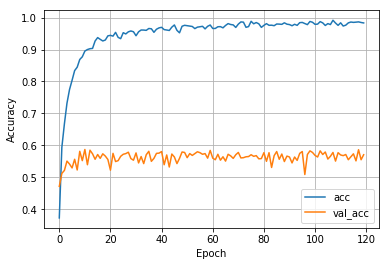

In [10]:
hist_his = hist.history
acc = hist_his['acc']
val_acc = hist_his['val_acc']
plt.plot(acc)
plt.plot(val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc','val_acc'], loc = 4)

## Plot the loss curve

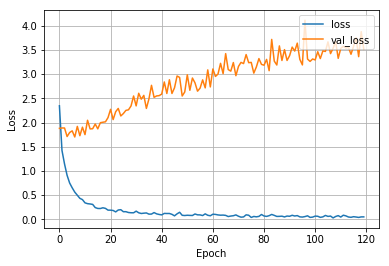

In [11]:
loss = hist_his['loss']
val_loss = hist_his['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc = 1)

In [12]:
print(loss)
print(val_loss)
print(acc)
print(val_acc)

[2.3461001035050724, 1.4235979016874845, 1.1430863561457525, 0.9086284632525168, 0.7497734822894895, 0.6507400545521362, 0.5618185450956527, 0.497515937167688, 0.4333582236034413, 0.4072008218772805, 0.3403918516956609, 0.32332254938371197, 0.3169648504349434, 0.30803932771492826, 0.24235950610026422, 0.22409920513116352, 0.22299199451120705, 0.2381320928285825, 0.22565900431023933, 0.1895868973198938, 0.18879720360218838, 0.18264092518734307, 0.15306884070741433, 0.19240670959727718, 0.19870258597465482, 0.15718773798697733, 0.15746098371291067, 0.14063597524793126, 0.13533142471598555, 0.13465000178611863, 0.16852534865377153, 0.13479207398729207, 0.11998056702503153, 0.12652170437751514, 0.1314194848541847, 0.1068851044963235, 0.10811103968444641, 0.13935735310389033, 0.11262571445435511, 0.09994827654374512, 0.09156880270822702, 0.12170841077027221, 0.11986629047051284, 0.12042203829077608, 0.10257396470124522, 0.07141154148305237, 0.11286345072888482, 0.14545853183142474, 0.082614

## Summary

Based on above accuracy and loss curves, we can clearly see that there exists severe overfitting. Obviously, we need to find out how we add layers can reduce overfitting as much as possible and maintain the accuracy at the same time. 

So we decide to use 3 classes which contains most paintings and 20 epochs as the starting point. To address overfiting, adding noises, regularization may help.  